In [139]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from scipy import stats
from itertools import product
from scipy import optimize
import matplotlib.cm as cm

import sys
sys.path.append("./vertex_subroutines")
from GAMcalc import *  # Code for calculating vertex functions
import propagator  # propagator object used to store pre-calculated values
import wignerD as wd # wigner D object used to store pre-calculated values

import importlib
from cga import *

import wlcstat.wlc_copoly as wlc_copoly

In [25]:
k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)
k1_vec = np.zeros((nk, 3))
k1_vec[:, 0] += np.logspace(np.log10(k0), np.log10(kf), nk)

#Polymer type 1
FA_1 = 0.5
N_1 = 100.
PHI_1 = 0.5

#Polymer type 2
FA_2 = 0.7
N_2 = N_1
PHI_2 = PHI_1

In [57]:
%%time
#dsswlc cga sf
n_p = 30000
num_snapshots = 1
DEL = 1
n_b_1 = int( (N_1*2)/DEL )
n_b_2 = int( (N_2*2)/DEL )

otpt_1 = dsswlc_cga(N_1, int(n_p*PHI_1), n_b_1 , FA_1, num_snapshots, DEL)
otpt_2 = dsswlc_cga(N_2, int(n_p*PHI_2), n_b_2, FA_2, num_snapshots, DEL)

#best sf calc- the one andy wrote
i_snap_f = num_snapshots-1
i_snap_0 = 0

s2_cga_1 = np.zeros(nk,  dtype = type(1 + 1j))
s2_cga_2 = np.zeros(nk,  dtype = type(1 + 1j))

for i_snap in range(num_snapshots):
    
    r_snap_1 = otpt_1
    r_snap_2 = otpt_2
    for i_p in range(int(n_p*PHI_1)): #NEED TO CHANGE WHEN NPs arent EUQAL
        i_0 = n_b_1 * i_p          #NEED TO CHANGE if diff lengths
        i_f = i_0 + n_b_1
        
        r_i_1 = r_snap_1[i_0:i_f, 0:3]/2
        sigma_i_1 = r_snap_1[i_0:i_f, 3] 
        sigma_j_1 = 1 - sigma_i_1 #1 - sigma_i_1
        
        r_i_2 = r_snap_2[i_0:i_f, 0:3]/2
        sigma_i_2 = r_snap_2[i_0:i_f, 3] 
        sigma_j_2 = 1 - sigma_i_2

        
        s_mat1 = sigma_i_1*(np.exp(1j * (np.outer(k1_vec[:, 0], r_i_1[:, 0]) + np.outer(k1_vec[:, 1], r_i_1[:, 1]) + np.outer(k1_vec[:, 2], r_i_1[:, 2]))))        
        s_mat2 = sigma_j_1*(np.exp(1j * (np.outer(-k1_vec[:, 0], r_i_1[:, 0]) + np.outer(-k1_vec[:, 1], r_i_1[:, 1]) + np.outer(-k1_vec[:, 2], r_i_1[:, 2]))))        
        s2_cga_1 += np.sum(s_mat1, axis = 1) * np.sum(s_mat2, axis = 1) / (n_b_1 ** 2 * (i_snap_f - i_snap_0 + 1) * n_p*PHI_1)
        #    
        
        s_mat1 = sigma_i_2*(np.exp(1j * (np.outer(k1_vec[:, 0], r_i_2[:, 0]) + np.outer(k1_vec[:, 1], r_i_2[:, 1]) + np.outer(k1_vec[:, 2], r_i_2[:, 2]))))        
        s_mat2 = sigma_j_2*(np.exp(1j * (np.outer(-k1_vec[:, 0], r_i_2[:, 0]) + np.outer(-k1_vec[:, 1], r_i_2[:, 1]) + np.outer(-k1_vec[:, 2], r_i_2[:, 2]))))        
        s2_cga_2 += np.sum(s_mat1, axis = 1) * np.sum(s_mat2, axis = 1) / (n_b_2 ** 2 * (i_snap_f - i_snap_0 + 1) * n_p*PHI_2)

Wall time: 1min 2s


In [26]:
#wlcstat (vertex) sf2

s2_thr_1 = wlc_copoly.s2_wlc_diblock(k_vec, N_1, FA_1, dimensions=3, alpha_max=25)

s2_thr_2 = wlc_copoly.s2_wlc_diblock(k_vec, N_2, FA_2, dimensions=3, alpha_max=25)

C:\Users\Thomas\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Thomas\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


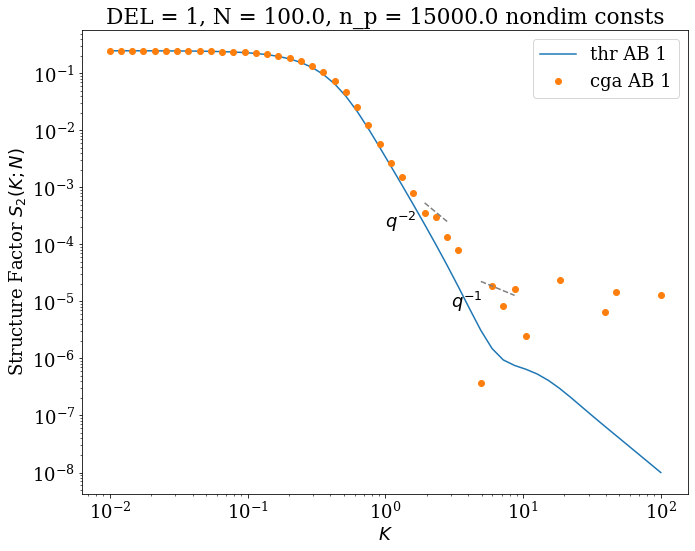

In [31]:
#Compare plots
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
    
plt.plot(k_vec, s2_thr_1[1],'-', label = "thr AB 1")
plt.plot(k_vec, s2_cga_1, "o", label = "cga AB 1")

plt.plot(k_vec[-22:-19], k_vec[-22:-19]**-(2) / 500, '--', color = "grey")
plt.plot(k_vec[-17:-13], k_vec[-17:-13]**-(1) / 9000, '--', color = "grey")

plt.xscale('log')
plt.yscale('log')

plt.title("DEL = " + str(DEL) + ", N = " + str(N_1) + ", n_p = " + str(n_p*PHI_1) + " polymer 1")
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')
plt.text(1, 0.0002, "$q^{-2}$")
plt.text(3, 0.000008, "$q^{-1}$")
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\Thomas\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Thomas\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


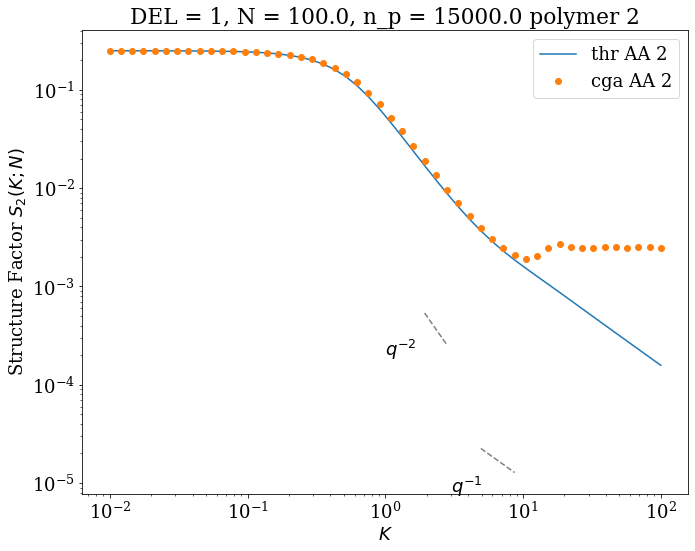

In [36]:
#Compare plots
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
    
plt.plot(k_vec, s2_thr_1[0],'-', label = "thr AA 2")
# plt.plot(k_vec, debye(k_vec), label = "debye AA") #debye is
#plt.plot(k_vec, s2_sim_cga_copoly, "x", color = "black", label = "cga AB dif vects")
plt.plot(k_vec, s2_cga_1, "o", label = "cga AA 2")

plt.plot(k_vec[-22:-19], k_vec[-22:-19]**-(2) / 500, '--', color = "grey")
plt.plot(k_vec[-17:-13], k_vec[-17:-13]**-(1) / 9000, '--', color = "grey")
# plt.plot(k_vec[-1:-10], k_vec[0:10]**-1 / 1000)
#plt.scatter([10.48], [9.3/100**2], color = "red")
#plt.scatter([10.48], [9.6/100**2], color = "purple")
#plt.plot(k_vec, s2_sim_cga_vect, color = "orange", label = "cga vect homo")
#plt.plot(k_vec, 1-s2_th,'-')    
#plt.plot(k_vec, 1-s2_asymp,'--')    

plt.xscale('log')
plt.yscale('log')

plt.title("DEL = " + str(DEL) + ", N = " + str(N_1) + ", n_p = " + str(n_p*PHI_1) + " polymer 2")
# plt.title("N = 10, n_p = " + str(n_p))
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')
#plt.xlim((1e-2, 1e2))
plt.text(1, 0.0002, "$q^{-2}$")
plt.text(3, 0.000008, "$q^{-1}$")
plt.legend()
plt.tight_layout()
plt.show()
#THETA 1, axes_2_orientation

C:\Users\Thomas\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Thomas\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Thomas\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Thomas\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


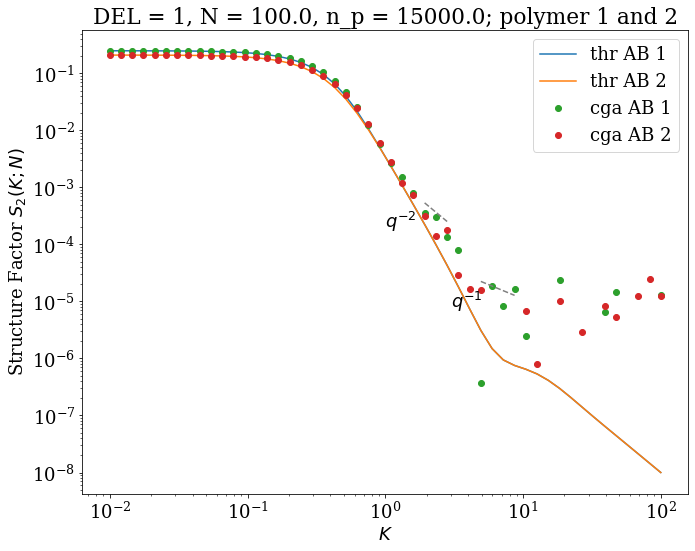

In [34]:
#Compare plots
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
    
plt.plot(k_vec, s2_thr_1[1],'-', label = "thr AB 1")
plt.plot(k_vec, s2_thr_2[1],'-', label = "thr AB 2")

plt.plot(k_vec, s2_cga_1, "o", label = "cga AB 1")
plt.plot(k_vec, s2_cga_2, "o", label = "cga AB 2")

plt.plot(k_vec[-22:-19], k_vec[-22:-19]**-(2) / 500, '--', color = "grey")
plt.plot(k_vec[-17:-13], k_vec[-17:-13]**-(1) / 9000, '--', color = "grey")
   

plt.xscale('log')
plt.yscale('log')

plt.title("DEL = " + str(DEL) + ", N = " + str(N_1) + ", n_p = " + str(n_p*PHI_1) + "; polymer 1 and 2")
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')
plt.text(1, 0.0002, "$q^{-2}$")
plt.text(3, 0.000008, "$q^{-1}$")
plt.legend()
plt.tight_layout()
plt.show()
#THETA 1, axes_2_orientation

In [79]:
#averaging structure factors

s2_thr_avgd = PHI_1*s2_thr_1[1] + PHI_2*s2_thr_2[1]
s2_cga_avgd = PHI_1*s2_cga_1 + PHI_2*s2_cga_2

#compare to sf of avgd fa polymer
FA_avg = FA_1*PHI_1 + FA_2*PHI_2
s2_thr_3 = wlc_copoly.s2_wlc_diblock(k_vec, N_2, FA_avg, dimensions=3, alpha_max=25)

In [65]:
FA_avg

0.6

C:\Users\Thomas\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Thomas\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


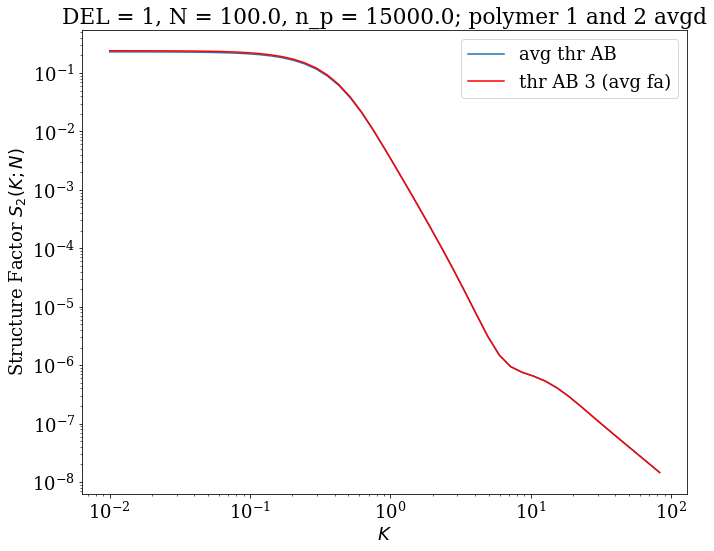

In [80]:
#Compare plots
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

endd = -1
plt.plot(k_vec[:endd], s2_thr_avgd[:endd],'-', label = "avg thr AB")
# plt.plot(k_vec[:endd], s2_thr_1[1][:endd],'-', label = "thr AB 1")
# plt.plot(k_vec[:endd], s2_thr_2[1][:endd],'-', label = "thr AB 2")

plt.plot(k_vec[:endd], s2_thr_3[1][:endd],'-', label = "thr AB 3 (avg fa)", color = "red")

# plt.plot(k_vec, s2_cga_avgd, "o", label = "avg cga AA")

# plt.plot(k_vec[-22:-19], k_vec[-22:-19]**-(2) / 50000, '--', color = "grey") #AB
# plt.plot(k_vec[-17:-13], k_vec[-17:-13]**-(1) / 900000, '--', color = "grey") #AB

# plt.plot(k_vec[-31:-28], k_vec[-31:-28]**-(2) / 300, '--', color = "grey") #AA
# plt.plot(k_vec[-26:-23], k_vec[-26:-23]**-(1) / 300, '--', color = "grey") #AA
   

plt.xscale('log')
plt.yscale('log')

plt.title("DEL = " + str(DEL) + ", N = " + str(N_1) + ", n_p = " + str(n_p*PHI_1) + "; polymer 1 and 2 avgd")
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')

# plt.text(1, 0.000002, "$q^{-2}$") #AB
# plt.text(3, 0.00000008, "$q^{-1}$") #AB

# plt.text(.28, 0.01, "$q^{-2}$") #AA
# plt.text(.7, 0.002, "$q^{-1}$") #AA

plt.legend()
plt.tight_layout()
plt.show()
#THETA 1, axes_2_orientation

In [ ]:
# TODO: handle averaging of polymers with different lengths!

In [185]:
def s2inverse_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, K):
    "returns the annealed disorder average of the 2 point sf inverse of a binary mixture of diblock copolymers"
    "CURRENTLY ONLY HANDLES POLYS OF SAME LENGTH"
    if (N_1 != N_2):
        raise Exception("Can only handle binary mix of polymers with same length")
        
    if norm(K) < 1e-5:
        s2inv = s2inverse_zeroq_polyd(N_1, N_2, PHI_1, FA) #TODO change so handles dif length polys
        return s2inv
    
    PHI_2 = 1 - PHI_1
    s2_1 = s2wlc(pset, N_1, FA_1, K)
    s2_2 = s2wlc(pset, N_2, FA_2, K)
    
    s2inv = np.zeros((2,2),dtype=type(1+1j))
    
    [s2aa_1, s2ab_1], [s2ba_1, s2bb_1] = s2_1
    [s2aa_2, s2ab_2], [s2ba_2, s2bb_2] = s2_2
    
    s2aa = PHI_1*s2aa_1+PHI_2*s2aa_2 # TODO: update these averages to consider N_1 != N_2
    s2ab = PHI_1*s2ab_1+PHI_2*s2ab_2
    s2ba = PHI_1*s2ba_1+PHI_2*s2ba_2
    s2bb = PHI_1*s2bb_1+PHI_2*s2bb_2
    
    det = s2aa*s2bb - s2ab*s2ba
    
    s2inv[0,0] = s2bb/det
    s2inv[0,1] = -s2ab/det
    s2inv[1,0] = -s2ba/det
    s2inv[1,1] = s2aa/det
    
    return s2inv

In [186]:
def s2inverse_zeroq_polyd(N_1, N_2, PHI_1, FA):
    s2 = np.ones((2,2),dtype='complex')
    N_ave = N_1 * PHI_1 + N_2 * (1-PHI_1)
    return s2/(N_ave**2)

In [159]:
# chemically averaged

def gamma2_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, K, CHI):
    #Only accepts two polymer types of same length
    PHI_2 = 1 - PHI_1
    
    s2inv = s2inverse_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, K,)

    D = [1,-1]    # sign indicator
    G = 0
    for I0, I1 in product([0,1], repeat=2):
        G += s2inv[I0, I1]*D[I0]*D[I1]
        
    return -2*CHI + (PHI_1*N_1 + PHI_2*N_2)*G #TODO: fix this averaging for polys w different length
# calc spinodal!

In [171]:
def spinodal_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1):
    CHI = 0
    K0 = 1/np.sqrt(r2(N))
    
    KS = optimize.fmin(lambda K: np.real(gamma2_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, K, CHI)), K0,\
                      disp=False)
    
    return KS

In [168]:
def gamma3_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, Ks):
    K1, K2, K3 = Ks
    if norm(K1+K2+K3) >= 1e-10:
        raise('Qs must add up to zero')
        
    if not (abs(norm(K1)-norm(K2)) < 1e-5 \
        and abs(norm(K2)-norm(K3)) < 1e-5):
        raise('Qs must have same length')
    
    PHI_2 = 1 - PHI_1
    
    s3 = PHI_1 * s3wlc(pset, N_1, FA_1, Ks) + PHI_2 * s3wlc(pset, N_2, FA_2, Ks) #TODO: fix this average for dif length polys
    
    s2inv = s2inverse_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, norm(K1))
    
    val = 0
    for I0, I1, I2 in product([0,1], repeat=3):
        val -= s3[I0][I1][I2]* (s2inv[I0][0] - s2inv[I0][1])*\
                               (s2inv[I1][0] - s2inv[I1][1])*\
                               (s2inv[I2][0] - s2inv[I2][1])

    return val*(N**2) #TODO: fix this averaging for polys w different length (N average)

In [188]:
def gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, Ks):
    K1, K2, K3, K4 = Ks
    if not (abs(norm(K1)-norm(K2)) < 1e-5
            and abs(norm(K2)-norm(K3)) < 1e-5
            and abs(norm(K3)-norm(K4)) < 1e-5):
        print(K1, K2, K3, K4)
        raise('Qs must have same length')
    
    PHI_2 = 1 - PHI_1
    
    K = norm(K1)
    K12 = norm(K1+K2)
    K13 = norm(K1+K3)
    K14 = norm(K1+K4)
    
    #TODO: change all these avgs for dif length polys
    s4 = PHI_1 * s4wlc(pset, wigset, N_1, FA_1, Ks) + PHI_2 * s4wlc(pset, wigset, N_2, FA_2, Ks)
    s31 = PHI_1 * s3wlc(pset, N_1, FA_1, [K1, K2, -K1-K2]) + PHI_2 * s3wlc(pset, N_2, FA_2, [K1, K2, -K1-K2])
    s32 = PHI_1 * s3wlc(pset, N_1, FA_1, [K1, K3, -K1-K3]) + PHI_2 * s3wlc(pset, N_2, FA_2, [K1, K3, -K1-K3])
    s33 = PHI_1 * s3wlc(pset, N_1, FA_1, [K1, K4, -K1-K4]) + PHI_2 * s3wlc(pset, N_2, FA_2, [K1, K4, -K1-K4])
    
    s2inv = s2inverse_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, K)
    s21inv = s2inverse_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, K12)
    s22inv = s2inverse_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, K13)
    s23inv = s2inverse_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, K14)

    G4 = np.zeros((2,2,2,2),dtype=type(1+1j))
    for a1, a2, a3, a4 in product([0,1], repeat=4):
        for I0, I1 in product([0,1], repeat=2):
            G4[a1][a2][a3][a4] += \
                s31[a1][a2][I0]*s31[a3][a4][I1]*s21inv[I0][I1] + \
                s32[a1][a4][I0]*s32[a2][a3][I1]*s22inv[I0][I1] + \
                s33[a1][a3][I0]*s33[a2][a4][I1]*s23inv[I0][I1]
    G4 -= s4
    
    val = 0
    for I0, I1, I2, I3 in product([0,1], repeat=4):
        val += G4[I0][I1][I2][I3] *\
                (s2inv[I0][0] - s2inv[I0][1])*\
                (s2inv[I1][0] - s2inv[I1][1])*\
                (s2inv[I2][0] - s2inv[I2][1])*\
                (s2inv[I3][0] - s2inv[I3][1])
                
    return val*(N**3) #TODO: fix this averaging for polys w different length

In [263]:

N_1 = 10000
N_2 = N_1
#f_as = np.arange(.3, 0.701, 0.1)#np.array([0.5, 0.7, 0.6]) #FA_1, FA_2, FA_3
f_as = np.arange(.2, 0.501, 0.05)
FA_2 = 0.5

In [ ]:
# Spinodal analysis

In [264]:
%%time

# monodisperse

spin_array_vertex = np.zeros(len(f_as))
for i, FA in enumerate(f_as):
    chis = np.arange(8, 24, 0.1)/N #np.arange(0, 40, 0.1) 
    min_G_vals = np.zeros(len(chis))
    for j,CHI in enumerate(chis):
        #evaluate gamma2 at the chi k_spinodal for appropriate length, find when equals zero
        KS = spinodal(pset, N, FA)
        G = gamma2(pset, N, FA, KS, CHI)
        min_G_vals[j] = G # b/c g2 is 1x1 matrix, eigenvalue is the value of g2 itself. 
    spin_array_vertex[i] = chis[np.argmin((abs(min_G_vals)))]

<timed exec>:11: ComplexWarning: Casting complex values to real discards the imaginary part


Wall time: 51.2 s


In [265]:
%%time
# polydisperse

PHI_1_arr = np.arange(0.9, 1.005, 0.01)
final_polyd_spin_array_vertex = np.zeros(len(PHI_1_arr), dtype = "object")
for k, PHI_1 in enumerate(PHI_1_arr):
    
    polyd_spin_array_vertex = np.zeros(len(f_as))
    chis = np.arange(8, 24, .1)/N #np.arange(8, 24, 0.1)

    for i, FA_1 in enumerate(f_as):
        min_G_vals = np.zeros(len(chis))
        for j,CHI in enumerate(chis):
            #evaluate gamma2 at the chi k_spinodal for appropriate length, find when equals zero
            KS = spinodal_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1)
            G = gamma2_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, KS, CHI)
            min_G_vals[j] = G # b/c g2 is 1x1 matrix, eigenvalue is the value of g2 itself. 

        polyd_spin_array_vertex[i] = chis[np.argmin((abs(min_G_vals)))]
    final_polyd_spin_array_vertex[k] = polyd_spin_array_vertex
    

<timed exec>:16: ComplexWarning: Casting complex values to real discards the imaginary part


Wall time: 12min 21s


Text(0, 0.5, '$\\chi N$')

<Figure size 432x288 with 0 Axes>

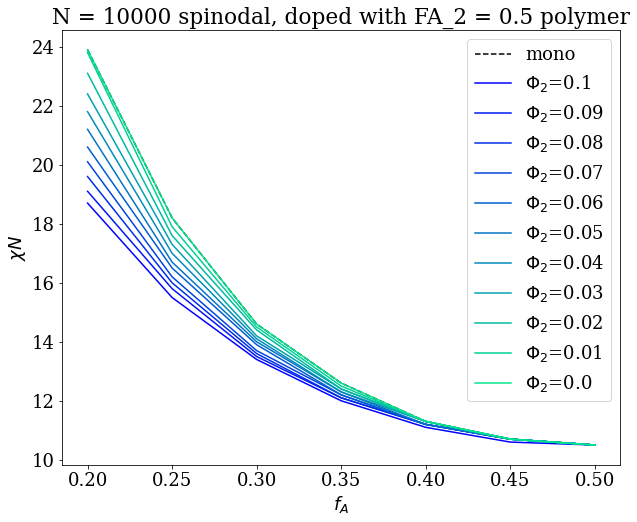

In [266]:

fig = plt.figure()
plt.figure(figsize=(10,8))

COLOR = iter(cm.winter(np.linspace(0, 1, len(PHI_1_arr)+1)))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)


ax.plot(f_as, spin_array_vertex*N, label="mono", linestyle = "--", color = "black")#, zorder = 0)
for k, PHI_1 in enumerate(PHI_1_arr):
    clr = next(COLOR)
    ax.plot(f_as, final_polyd_spin_array_vertex[k]*N, label="$\Phi_2$=" + str(np.round(1-PHI_1, 2)), color = clr)

# ax.plot(f_as[2:], polyd_spin_array_vertex[2:]*N, label="PHI=0.5, FA=0.5", color = "red")#, zorder = 0)
plt.title("N = " + str(N) + " spinodal, doped with FA_2 = " + str(np.round(FA_2, 2)) + " polymer")
plt.legend()
plt.xlabel(r'$f_A$')
plt.ylabel(r'$\chi N$')

Text(0, 0.5, '$\\chi N$')

<Figure size 432x288 with 0 Axes>

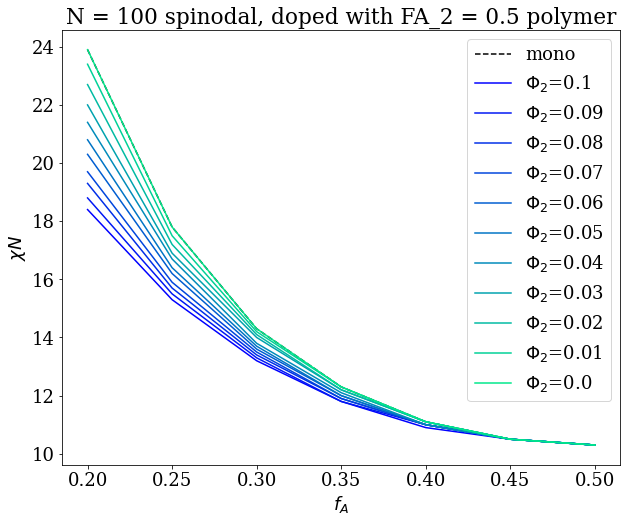

In [148]:

fig = plt.figure()
plt.figure(figsize=(10,8))

COLOR = iter(cm.winter(np.linspace(0, 1, len(PHI_1_arr)+1)))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)


ax.plot(f_as, spin_array_vertex*N, label="mono", linestyle = "--", color = "black")#, zorder = 0)
for k, PHI_1 in enumerate(PHI_1_arr):
    clr = next(COLOR)
    ax.plot(f_as, final_polyd_spin_array_vertex[k]*N, label="$\Phi_2$=" + str(np.round(1-PHI_1, 2)), color = clr)

# ax.plot(f_as[2:], polyd_spin_array_vertex[2:]*N, label="PHI=0.5, FA=0.5", color = "red")#, zorder = 0)
plt.title("N = 100 spinodal, doped with FA_2 = 0.5 polymer")
plt.legend()
plt.xlabel(r'$f_A$')
plt.ylabel(r'$\chi N$')

Text(0, 0.5, '$\\chi N$')

<Figure size 432x288 with 0 Axes>

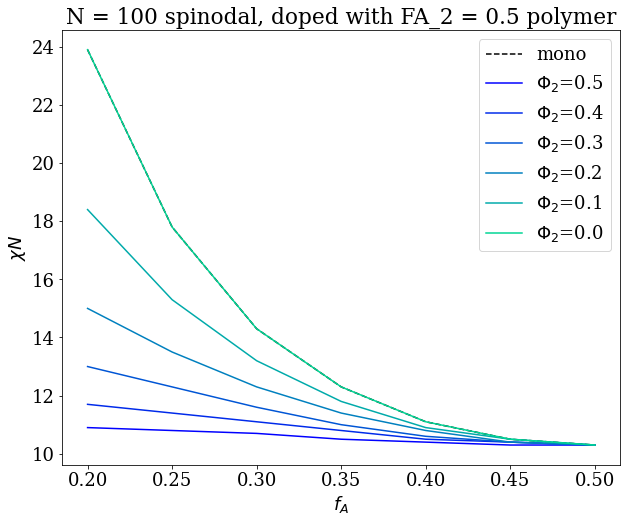

In [146]:
#monodisperse vs polydisperse, 50% changes, 50% is FA = 0.5
fig = plt.figure()
plt.figure(figsize=(10,8))

COLOR = iter(cm.winter(np.linspace(0, 1, len(PHI_1_arr)+1)))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)


ax.plot(f_as, spin_array_vertex*N, label="mono", linestyle = "--", color = "black")#, zorder = 0)
for k, PHI_1 in enumerate(PHI_1_arr):
    clr = next(COLOR)
    ax.plot(f_as, final_polyd_spin_array_vertex[k]*N, label="$\Phi_2$=" + str(np.round(1-PHI_1, 2)), color = clr)

# ax.plot(f_as[2:], polyd_spin_array_vertex[2:]*N, label="PHI=0.5, FA=0.5", color = "red")#, zorder = 0)
plt.title("N = 100 spinodal, doped with FA_2 = 0.5 polymer")
plt.legend()
plt.xlabel(r'$f_A$')
plt.ylabel(r'$\chi N$')

In [ ]:
#k* vs FA2, Phi2 analysis

In [234]:
1-np.arange(0, 0.11, 0.01)

array([1.  , 0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.9 ])

In [235]:
np.zeros(5, dtype = object)

array([0, 0, 0, 0, 0], dtype=object)

In [274]:
# for a constant FA2 of 0.5, how does changing PHI2 change k*
N = 100
N_1 = N
N_2 = N_1
FA_2 = 0.5

fa_array = [0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45, 0.475, 0.5]
# fa_array = np.arange(.3, 0.701, 0.1)
PHI2_range = np.arange(0, 0.11, 0.01)
PHI1_range = 1 - PHI2_range

rslt = np.zeros(len(PHI1_range), dtype = object)
for i, PHI_1 in enumerate(PHI1_range):
    phi_rslt = np.zeros(len(fa_array))
    for j,FA_1 in enumerate(fa_array):
        KS = spinodal_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1)
        phi_rslt[j] = KS
    rslt[i] = phi_rslt  



Text(0.5, 0, '$f_A$')

<Figure size 432x288 with 0 Axes>

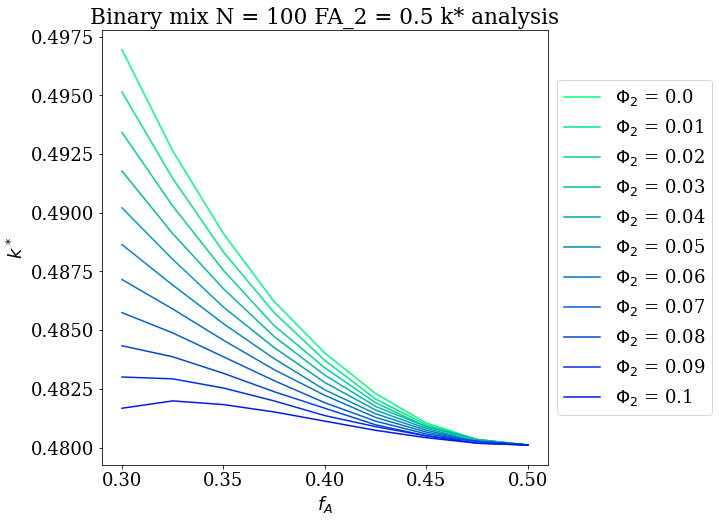

In [275]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)

COLOR = iter(cm.winter(np.linspace(1, 0, len(PHI2_range)+1)))

for i, PHI_2 in enumerate(PHI2_range):
    clr = next(COLOR)
    ax.plot(fa_array, rslt[i], label = "$\Phi_2$ = " + np.str(np.round(PHI_2, 2)), color = clr)
plt.legend()

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Binary mix N = " + str(N) + " FA_2 = " +  str(np.round(FA_2, 2)) + " k* analysis")
ax.set_ylabel("$k^*$")
ax.set_xlabel("$f_A$")

In [ ]:
#gam2 vs k* analysis

In [333]:
np.arange(0.3, 0.601, 0.1)

array([0.3, 0.4, 0.5, 0.6])

In [334]:
#monodisperse
N = 10000
CHI = 0

fa_array = np.arange(0.3, 0.601, 0.1)#[0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45, 0.475, 0.5]
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)
G2_arr = np.zeros(len(fa_array), dtype = object)
for i, FA in enumerate(fa_array):
    fa_arr = np.zeros(len(k_vec))
    for j, K in enumerate(k_vec):
        G2 = gamma2(pset, N, FA, K, CHI)
        fa_arr[j] = G2
    G2_arr[i] = fa_arr


<ipython-input-334-8846f9bcd24e>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  fa_arr[j] = G2


Text(0, 0.5, '$\\Gamma_2$')

<Figure size 432x288 with 0 Axes>

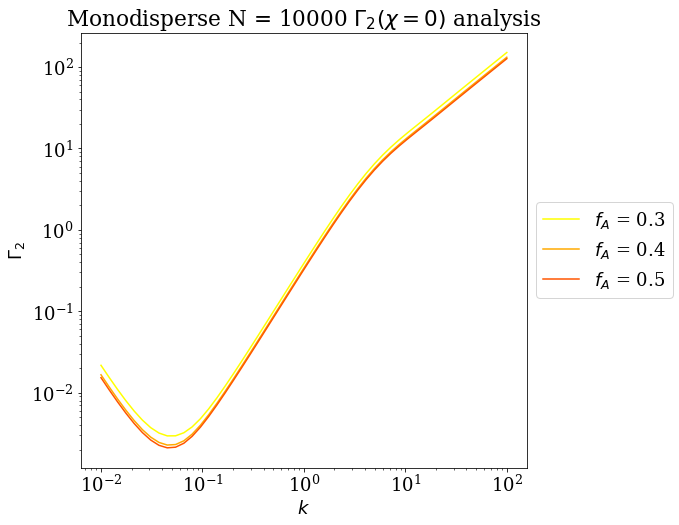

In [319]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)

COLOR = iter(cm.autumn(np.linspace(1, 0, len(fa_array)+1)))

for i, FA in enumerate(fa_array):
    clr = next(COLOR)
    ax.plot(k_vec, G2_arr[i], label = "$f_A$ = " + np.str(np.round(FA, 2)), color = clr)
plt.legend()

plt.xscale('log')
plt.yscale('log')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Monodisperse N = " + str(N) + " $\Gamma_2 (\chi = 0) $ analysis")
ax.set_xlabel("$k$")
ax.set_ylabel("$\Gamma_2$")

In [341]:
#polydisperse
PHI_2 = 0.1
PHI_1 = 1 - PHI_2
FA_2 = 0.5
CHI = 0

N = 10000
N_1 = N
N_2 = N_1

fa_array = np.arange(0.3, 0.601, 0.1)#[0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45, 0.475, 0.5]
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)
G2_arr_poly = np.zeros(len(fa_array), dtype = object)
for i, FA_1 in enumerate(fa_array):
    fa_arr = np.zeros(len(k_vec))
    for j, K in enumerate(k_vec):
        G2 = gamma2_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, K, CHI)
        fa_arr[j] = G2
    G2_arr_poly[i] = fa_arr


<ipython-input-341-22efd8fc0fda>:18: ComplexWarning: Casting complex values to real discards the imaginary part
  fa_arr[j] = G2


Text(0, 0.5, '$\\Gamma_2$')

<Figure size 432x288 with 0 Axes>

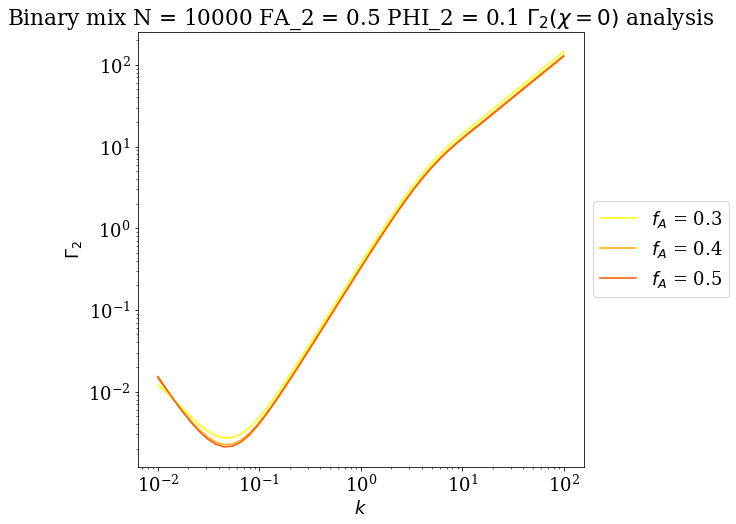

In [314]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)

COLOR = iter(cm.autumn(np.linspace(1, 0, len(fa_array)+1)))

for i, FA in enumerate(fa_array):
    clr = next(COLOR)
    ax.plot(k_vec, G2_arr_poly[i], label = "$f_A$ = " + np.str(np.round(FA, 2)), color = clr)
plt.legend()

plt.xscale('log')
plt.yscale('log')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Binary mix N = " + str(N) + " FA_2 = " +  str(np.round(FA_2, 2)) + " PHI_2 = " + str(np.round(PHI_2, 2)) +" $\Gamma_2 (\chi = 0) $ analysis")
ax.set_xlabel("$k$")
ax.set_ylabel("$\Gamma_2$")

In [337]:
fa_array

array([0.3, 0.4, 0.5, 0.6])

Text(0, 0.5, '$\\Gamma_2$')

<Figure size 432x288 with 0 Axes>

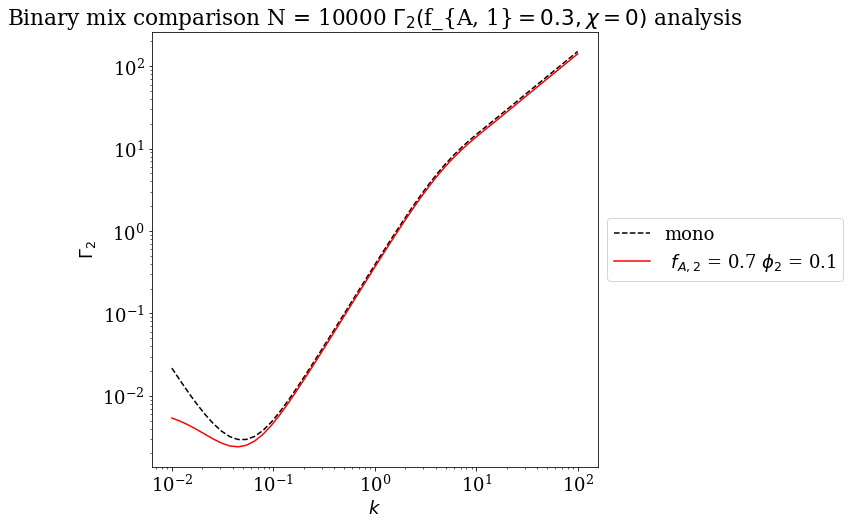

In [340]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)

COLOR = iter(cm.autumn(np.linspace(1, 0, len(fa_array)+1)))
for i, FA in enumerate(fa_array):
    if np.round(FA, 2) == 0.3:
        clr = next(COLOR)
        clr = "red"
        ax.plot(k_vec, G2_arr[i], label = "mono", color = "black", linestyle = "dashed")
        ax.plot(k_vec, G2_arr_poly[i], label = " $f_{A,2}$ = " +  str(np.round(FA_2, 2)) + " $\phi_2$ = " + str(np.round(PHI_2, 2)) , color = clr)
plt.legend()

plt.xscale('log')
plt.yscale('log')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Binary mix comparison N = " + str(N) + " $\Gamma_2 ($f_{A, 1}$ = 0.3, \chi = 0) $ analysis")
ax.set_xlabel("$k$")
ax.set_ylabel("$\Gamma_2$")

In [ ]:
# phase diagram analysis

In [189]:
gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([lam_q, -lam_q, lam_q, -lam_q]))

(16.207190147498295-1.2326592647657296e-13j)

In [182]:
gamma4(pset, wigset, N_1, FA_1,  np.array([lam_q, -lam_q, lam_q, -lam_q]))

(16.207190147498295-1.2326592647657296e-13j)

In [223]:
%%time
#SINGLE WAVEMODE PHASE DIAGRAM binary mixture
N = 10000
N_1 = N
N_2 = N_1

PHI_1 = 1.0
FA_2 = 0.7

fa_array = [0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45, 0.475, 0.5]#[0.3, 0.325, 0.35, 0.375, 0.3875, 0.4, 0.4125, 0.425, 0.4375, 0.45, 0.475, 0.5]#[0.3, 0.35, 0.4, 0.45, 0.5]#np.arange(0.2, 0.51, .02)
fa_array = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7] #for FA2 != 0.5
chi_array = np.arange(5, 20, 0.5)/N #np.arange(5, 30, 0.5)/N #np.array([5, 7, 10, 12, 15, 17, 20])/N #* N
cyl_pnts = np.array([])
lam_pnts = np.array([])
gyr_pnts = np.array([])
sq_cyl_pnts = np.array([])
dis_pnts = np.array([])

for FA_1 in fa_array:
    KS = spinodal_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1)
    q_star = KS[0]

    lam_q = q_star*np.array([1, 0, 0])
    
    cyl_q1 = q_star*np.array([1, 0, 0])
    cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
    cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
    cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])
    
    sq_6 = (1/np.sqrt(6)) * q_star
    gyr_q1 = sq_6*np.array([-1, 2, 1])
    gyr_q2 = sq_6*np.array([2, 1, -1])
    gyr_q3 = sq_6*np.array([1, -1, 2])
    gyr_q4 = sq_6*np.array([2, -1, -1])
    gyr_q5 = sq_6*np.array([-1, 2, -1])
    gyr_q6 = sq_6*np.array([-1, -1, 2])
    
    gyr_q7 = sq_6*np.array([2, 1, 1])
    gyr_q8 = sq_6*np.array([1, 2, 1])
    gyr_q9 = sq_6*np.array([1, 1, 2])
    gyr_q10 = sq_6*np.array([2, -1, 1])
    gyr_q11 = sq_6*np.array([1, 2, -1])
    gyr_q12 = sq_6*np.array([-1, 1, 2])
    
    sq_cyl_q1 = q_star * np.array([1,0,0])
    sq_cyl_q2 = q_star * np.array([0,1,0])
    
    lam_g3 = 0
    
    cyl_g3 = (1/6) * (1/(3*np.sqrt(3))) * 12 * gamma3_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, cyl_qs)
        
    gyr_g3 = (1/6) * (1/(12*np.sqrt(12))) * 48 * gamma3_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q7, -gyr_q11, -gyr_q3]))
    
    sq_cyl_g3 = 0
    
    lam_g4 = (1/24) * (6) * (1) * gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([lam_q, -lam_q, lam_q, -lam_q]))
    
    cyl_g4 = (1/12)* (gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ])) + \
              4*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2])))
    
    gyr_g4 = (1/48) * (gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q1, -gyr_q1, gyr_q1, -gyr_q1])) + \
                       4*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q7, -gyr_q7, gyr_q8, -gyr_q8])) + \
                       4*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q7, -gyr_q7, gyr_q10, -gyr_q10])) + \
                       4*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q7, -gyr_q7, gyr_q11, -gyr_q11])) + \
                       2*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q7, -gyr_q7, gyr_q4, -gyr_q4])) + \
                       8*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q7, -gyr_q7, gyr_q12, -gyr_q12])) + \
                       -4*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q1, gyr_q4, -gyr_q10, -gyr_q5])) + \
                       2*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q7, -gyr_q2, gyr_q4, -gyr_q10])) + \
                       -4*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q1, -gyr_q5, -gyr_q7, gyr_q2])))
    
    sq_cyl_g4 = (1/24) * (1/4) * (12*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([sq_cyl_q1 , -sq_cyl_q1 , sq_cyl_q1 , -sq_cyl_q1 ])) + \
                                  24*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([sq_cyl_q1 , -sq_cyl_q1 , sq_cyl_q2 , -sq_cyl_q2 ])))
    
    for CHI in chi_array:
        lam_g2 = (1/2) * 2 * (1) * gamma2_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, q_star, CHI)                
        
        cyl_g2 = (1/2) * 6 * (1/3) * gamma2_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, q_star, CHI) 
        
        gyr_g2 = (1/2) * 24 * (1/12) * gamma2_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, q_star, CHI)
        
        sq_cyl_g2 = (1/2) * (1/2) * 4 * gamma2_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, q_star, CHI)
                                            
        
        amp_l1 = optimize.fmin(lambda amps: np.real(amps**2 * lam_g2 + amps**3 * lam_g3 + amps**4 * lam_g4), \
                              1, disp=False)
        amp_c1 = optimize.fmin(lambda amps: np.real(amps**2 * cyl_g2 + amps**3 * cyl_g3 + amps**4 * cyl_g4), \
                              1, disp=False)
        
        amp_g1 = optimize.fmin(lambda amps: np.real(amps**2 * gyr_g2 + amps**3 * gyr_g3 + amps**4 * gyr_g4), \
                              1, disp=False)
        
        amp_sq_c1 = optimize.fmin(lambda amps: np.real(amps**2 * sq_cyl_g2 + amps**3 * sq_cyl_g3 + amps**4 * sq_cyl_g4), \
                              1, disp=False)
        
        lamF = amp_l1**2 * lam_g2 + amp_l1**3 * lam_g3 + amp_l1**4 * lam_g4 
        
        cylF = amp_c1**2 * cyl_g2 + amp_c1**3 * cyl_g3 + amp_c1**4 * cyl_g4 
        
        gyrF = amp_g1**2 * gyr_g2 + amp_g1**3 * gyr_g3 + amp_g1**4 * gyr_g4 
        
        sq_cylF = amp_sq_c1**2 * sq_cyl_g2 + amp_sq_c1**3 * sq_cyl_g3 + amp_sq_c1**4 * sq_cyl_g4 
        
        
        point = np.array([FA_1, CHI*N])
#         if (lamF > 0 and cylF > 0):
#             #disordered stable
#             dis_pnts = np.append(dis_pnts, point)
#         elif (lamF < cylF):
#             lam_pnts = np.append(lam_pnts, point) 
#         else:
#             cyl_pnts = np.append(cyl_pnts, point)

        if (lamF > 0 and cylF > 0 and gyrF > 0 and sq_cylF > 0):
            #disordered stable
            dis_pnts = np.append(dis_pnts, point)
        elif (lamF < cylF and lamF < gyrF and lamF < sq_cylF):
            lam_pnts = np.append(lam_pnts, point) 
        elif (cylF < gyrF and cylF < sq_cylF):
            cyl_pnts = np.append(cyl_pnts, point)
        elif (gyrF < sq_cylF):
            gyr_pnts = np.append(gyr_pnts, point)
        else:
            sq_cyl_pnts = np.append(sq_cyl_pnts, point)
            
    print("one FA done!!")
            

one FA done!!
one FA done!!
one FA done!!
one FA done!!
one FA done!!
one FA done!!
one FA done!!
one FA done!!
one FA done!!
Wall time: 1h 58min 35s


Text(0.5, 0, '$f_A$')

<Figure size 432x288 with 0 Axes>

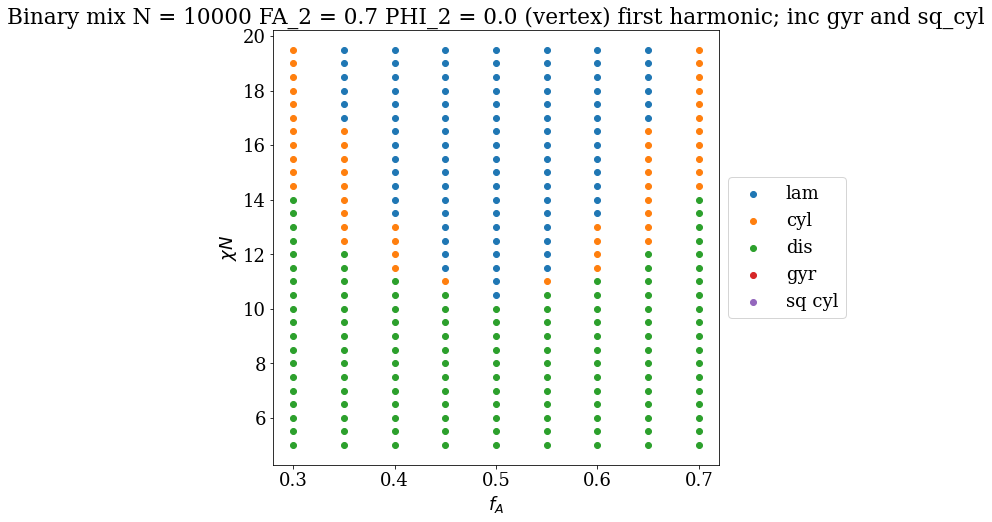

In [224]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)


# ax.plot(f_as, polyd_spin_array_vertex*N, label="monodisperse spinodal", color = "black")#, zorder = 0)
ax.scatter(lam_pnts[::2], lam_pnts[1::2], label = "lam")
ax.scatter(cyl_pnts[::2], cyl_pnts[1::2], label = "cyl")
ax.scatter(dis_pnts[::2], dis_pnts[1::2], label = "dis")
ax.scatter(gyr_pnts[::2], gyr_pnts[1::2], label = "gyr")
ax.scatter(sq_cyl_pnts[::2], sq_cyl_pnts[1::2], label = "sq cyl")
# ax.scatter([0.3, 0.4, 0.5], [19.204, 11.338, 8.981], label = "solv eff N=10 cyl/lam")
# ax.scatter([0.4, 0.5], [12.96, 10.25], label = "solv eff N=100 cyl/lam")

# ax.scatter([0.4, 0.425], [12.711, 11.689], label = "milner cyl/lam") #no gyr
# ax.scatter([0.375, 0.4, 0.425, .425, 0.44, 0.408], [12.745, 12.111, 11.512, 12.033, 11.25, 12.75], color = "brown", label = "milner gyroid")
# ax.scatter([0.4, 0.42, 0.42, 0.44, 0.44, 0.45], [12.722, 11.915, 13.044, 11.310, 11.671, 11.169], color = "purple", label = "matsen bates gyroid")


box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Binary mix N = " + str(N) + " FA_2 = " +  str(np.round(FA_2, 2)) +  " PHI_2 = " +str(np.round(1 - PHI_1, 2)) + " (vertex) first harmonic; inc gyr and sq_cyl")
ax.set_ylabel("$\chi N$")
ax.set_xlabel("$f_A$")
# ax.set_ylim(10, 13)

In [225]:
%%time
#SINGLE WAVEMODE PHASE DIAGRAM binary mixture
N = 10000
N_1 = N
N_2 = N_1

PHI_1 = .95
FA_2 = 0.7

fa_array = [0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45, 0.475, 0.5]#[0.3, 0.325, 0.35, 0.375, 0.3875, 0.4, 0.4125, 0.425, 0.4375, 0.45, 0.475, 0.5]#[0.3, 0.35, 0.4, 0.45, 0.5]#np.arange(0.2, 0.51, .02)
fa_array = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7] 
chi_array = np.arange(5, 20, 0.5)/N #np.arange(5, 30, 0.5)/N #np.array([5, 7, 10, 12, 15, 17, 20])/N #* N
cyl_pnts = np.array([])
lam_pnts = np.array([])
gyr_pnts = np.array([])
sq_cyl_pnts = np.array([])
dis_pnts = np.array([])

for FA_1 in fa_array:
    KS = spinodal_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1)
    q_star = KS[0]

    lam_q = q_star*np.array([1, 0, 0])
    
    cyl_q1 = q_star*np.array([1, 0, 0])
    cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
    cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
    cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])
    
    sq_6 = (1/np.sqrt(6)) * q_star
    gyr_q1 = sq_6*np.array([-1, 2, 1])
    gyr_q2 = sq_6*np.array([2, 1, -1])
    gyr_q3 = sq_6*np.array([1, -1, 2])
    gyr_q4 = sq_6*np.array([2, -1, -1])
    gyr_q5 = sq_6*np.array([-1, 2, -1])
    gyr_q6 = sq_6*np.array([-1, -1, 2])
    
    gyr_q7 = sq_6*np.array([2, 1, 1])
    gyr_q8 = sq_6*np.array([1, 2, 1])
    gyr_q9 = sq_6*np.array([1, 1, 2])
    gyr_q10 = sq_6*np.array([2, -1, 1])
    gyr_q11 = sq_6*np.array([1, 2, -1])
    gyr_q12 = sq_6*np.array([-1, 1, 2])
    
    sq_cyl_q1 = q_star * np.array([1,0,0])
    sq_cyl_q2 = q_star * np.array([0,1,0])
    
    lam_g3 = 0
    
    cyl_g3 = (1/6) * (1/(3*np.sqrt(3))) * 12 * gamma3_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, cyl_qs)
        
    gyr_g3 = (1/6) * (1/(12*np.sqrt(12))) * 48 * gamma3_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q7, -gyr_q11, -gyr_q3]))
    
    sq_cyl_g3 = 0
    
    lam_g4 = (1/24) * (6) * (1) * gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([lam_q, -lam_q, lam_q, -lam_q]))
    
    cyl_g4 = (1/12)* (gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ])) + \
              4*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2])))
    
    gyr_g4 = (1/48) * (gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q1, -gyr_q1, gyr_q1, -gyr_q1])) + \
                       4*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q7, -gyr_q7, gyr_q8, -gyr_q8])) + \
                       4*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q7, -gyr_q7, gyr_q10, -gyr_q10])) + \
                       4*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q7, -gyr_q7, gyr_q11, -gyr_q11])) + \
                       2*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q7, -gyr_q7, gyr_q4, -gyr_q4])) + \
                       8*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q7, -gyr_q7, gyr_q12, -gyr_q12])) + \
                       -4*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q1, gyr_q4, -gyr_q10, -gyr_q5])) + \
                       2*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q7, -gyr_q2, gyr_q4, -gyr_q10])) + \
                       -4*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q1, -gyr_q5, -gyr_q7, gyr_q2])))
    
    sq_cyl_g4 = (1/24) * (1/4) * (12*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([sq_cyl_q1 , -sq_cyl_q1 , sq_cyl_q1 , -sq_cyl_q1 ])) + \
                                  24*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([sq_cyl_q1 , -sq_cyl_q1 , sq_cyl_q2 , -sq_cyl_q2 ])))
    
    for CHI in chi_array:
        lam_g2 = (1/2) * 2 * (1) * gamma2_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, q_star, CHI)                
        
        cyl_g2 = (1/2) * 6 * (1/3) * gamma2_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, q_star, CHI) 
        
        gyr_g2 = (1/2) * 24 * (1/12) * gamma2_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, q_star, CHI)
        
        sq_cyl_g2 = (1/2) * (1/2) * 4 * gamma2_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, q_star, CHI)
                                            
        
        amp_l1 = optimize.fmin(lambda amps: np.real(amps**2 * lam_g2 + amps**3 * lam_g3 + amps**4 * lam_g4), \
                              1, disp=False)
        amp_c1 = optimize.fmin(lambda amps: np.real(amps**2 * cyl_g2 + amps**3 * cyl_g3 + amps**4 * cyl_g4), \
                              1, disp=False)
        
        amp_g1 = optimize.fmin(lambda amps: np.real(amps**2 * gyr_g2 + amps**3 * gyr_g3 + amps**4 * gyr_g4), \
                              1, disp=False)
        
        amp_sq_c1 = optimize.fmin(lambda amps: np.real(amps**2 * sq_cyl_g2 + amps**3 * sq_cyl_g3 + amps**4 * sq_cyl_g4), \
                              1, disp=False)
        
        lamF = amp_l1**2 * lam_g2 + amp_l1**3 * lam_g3 + amp_l1**4 * lam_g4 
        
        cylF = amp_c1**2 * cyl_g2 + amp_c1**3 * cyl_g3 + amp_c1**4 * cyl_g4 
        
        gyrF = amp_g1**2 * gyr_g2 + amp_g1**3 * gyr_g3 + amp_g1**4 * gyr_g4 
        
        sq_cylF = amp_sq_c1**2 * sq_cyl_g2 + amp_sq_c1**3 * sq_cyl_g3 + amp_sq_c1**4 * sq_cyl_g4 
        
        
        point = np.array([FA_1, CHI*N])
#         if (lamF > 0 and cylF > 0):
#             #disordered stable
#             dis_pnts = np.append(dis_pnts, point)
#         elif (lamF < cylF):
#             lam_pnts = np.append(lam_pnts, point) 
#         else:
#             cyl_pnts = np.append(cyl_pnts, point)

        if (lamF > 0 and cylF > 0 and gyrF > 0 and sq_cylF > 0):
            #disordered stable
            dis_pnts = np.append(dis_pnts, point)
        elif (lamF < cylF and lamF < gyrF and lamF < sq_cylF):
            lam_pnts = np.append(lam_pnts, point) 
        elif (cylF < gyrF and cylF < sq_cylF):
            cyl_pnts = np.append(cyl_pnts, point)
        elif (gyrF < sq_cylF):
            gyr_pnts = np.append(gyr_pnts, point)
        else:
            sq_cyl_pnts = np.append(sq_cyl_pnts, point)
            
    print("one FA done!!")
            

one FA done!!
one FA done!!
one FA done!!
one FA done!!
one FA done!!
one FA done!!
one FA done!!
one FA done!!
one FA done!!
Wall time: 1h 57min 6s


Text(0.5, 0, '$f_A$')

<Figure size 432x288 with 0 Axes>

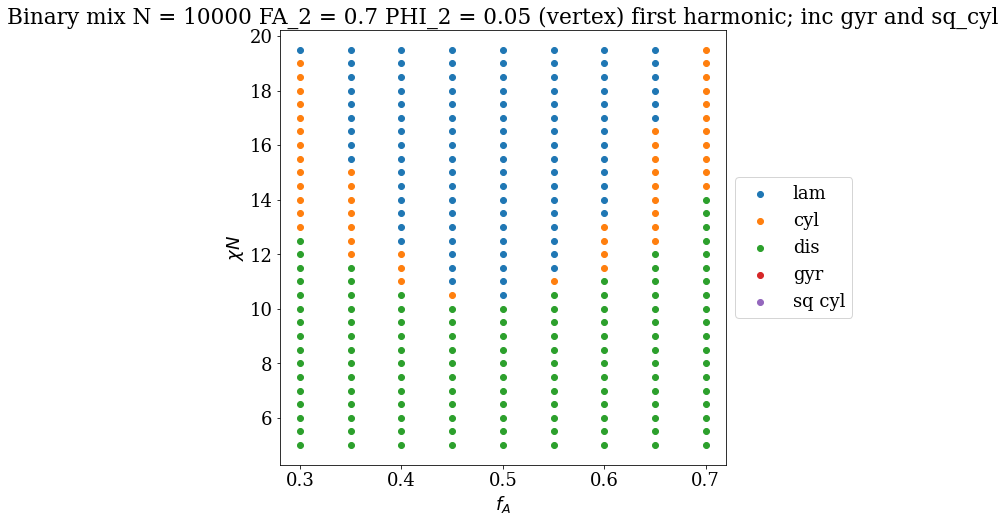

In [226]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)


# ax.plot(f_as, polyd_spin_array_vertex*N, label="monodisperse spinodal", color = "black")#, zorder = 0)
ax.scatter(lam_pnts[::2], lam_pnts[1::2], label = "lam")
ax.scatter(cyl_pnts[::2], cyl_pnts[1::2], label = "cyl")
ax.scatter(dis_pnts[::2], dis_pnts[1::2], label = "dis")
ax.scatter(gyr_pnts[::2], gyr_pnts[1::2], label = "gyr")
ax.scatter(sq_cyl_pnts[::2], sq_cyl_pnts[1::2], label = "sq cyl")
# ax.scatter([0.3, 0.4, 0.5], [19.204, 11.338, 8.981], label = "solv eff N=10 cyl/lam")
# ax.scatter([0.4, 0.5], [12.96, 10.25], label = "solv eff N=100 cyl/lam")

# ax.scatter([0.4, 0.425], [12.711, 11.689], label = "milner cyl/lam") #no gyr
# ax.scatter([0.375, 0.4, 0.425, .425, 0.44, 0.408], [12.745, 12.111, 11.512, 12.033, 11.25, 12.75], color = "brown", label = "milner gyroid")
# ax.scatter([0.4, 0.42, 0.42, 0.44, 0.44, 0.45], [12.722, 11.915, 13.044, 11.310, 11.671, 11.169], color = "purple", label = "matsen bates gyroid")


box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Binary mix N = " + str(N) + " FA_2 = " +  str(np.round(FA_2, 2)) +  " PHI_2 = " +str(np.round(1 - PHI_1, 2)) + " (vertex) first harmonic; inc gyr and sq_cyl")
ax.set_ylabel("$\chi N$")
ax.set_xlabel("$f_A$")
# ax.set_ylim(10, 13)

In [227]:
%%time
#SINGLE WAVEMODE PHASE DIAGRAM binary mixture
N = 10000
N_1 = N
N_2 = N_1

PHI_1 = .9
FA_2 = 0.7

fa_array = [0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45, 0.475, 0.5]#[0.3, 0.325, 0.35, 0.375, 0.3875, 0.4, 0.4125, 0.425, 0.4375, 0.45, 0.475, 0.5]#[0.3, 0.35, 0.4, 0.45, 0.5]#np.arange(0.2, 0.51, .02)
fa_array = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7] 
chi_array = np.arange(5, 20, 0.5)/N #np.arange(5, 30, 0.5)/N #np.array([5, 7, 10, 12, 15, 17, 20])/N #* N
cyl_pnts = np.array([])
lam_pnts = np.array([])
gyr_pnts = np.array([])
sq_cyl_pnts = np.array([])
dis_pnts = np.array([])

for FA_1 in fa_array:
    KS = spinodal_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1)
    q_star = KS[0]

    lam_q = q_star*np.array([1, 0, 0])
    
    cyl_q1 = q_star*np.array([1, 0, 0])
    cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
    cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
    cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])
    
    sq_6 = (1/np.sqrt(6)) * q_star
    gyr_q1 = sq_6*np.array([-1, 2, 1])
    gyr_q2 = sq_6*np.array([2, 1, -1])
    gyr_q3 = sq_6*np.array([1, -1, 2])
    gyr_q4 = sq_6*np.array([2, -1, -1])
    gyr_q5 = sq_6*np.array([-1, 2, -1])
    gyr_q6 = sq_6*np.array([-1, -1, 2])
    
    gyr_q7 = sq_6*np.array([2, 1, 1])
    gyr_q8 = sq_6*np.array([1, 2, 1])
    gyr_q9 = sq_6*np.array([1, 1, 2])
    gyr_q10 = sq_6*np.array([2, -1, 1])
    gyr_q11 = sq_6*np.array([1, 2, -1])
    gyr_q12 = sq_6*np.array([-1, 1, 2])
    
    sq_cyl_q1 = q_star * np.array([1,0,0])
    sq_cyl_q2 = q_star * np.array([0,1,0])
    
    lam_g3 = 0
    
    cyl_g3 = (1/6) * (1/(3*np.sqrt(3))) * 12 * gamma3_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, cyl_qs)
        
    gyr_g3 = (1/6) * (1/(12*np.sqrt(12))) * 48 * gamma3_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q7, -gyr_q11, -gyr_q3]))
    
    sq_cyl_g3 = 0
    
    lam_g4 = (1/24) * (6) * (1) * gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([lam_q, -lam_q, lam_q, -lam_q]))
    
    cyl_g4 = (1/12)* (gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ])) + \
              4*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2])))
    
    gyr_g4 = (1/48) * (gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q1, -gyr_q1, gyr_q1, -gyr_q1])) + \
                       4*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q7, -gyr_q7, gyr_q8, -gyr_q8])) + \
                       4*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q7, -gyr_q7, gyr_q10, -gyr_q10])) + \
                       4*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q7, -gyr_q7, gyr_q11, -gyr_q11])) + \
                       2*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q7, -gyr_q7, gyr_q4, -gyr_q4])) + \
                       8*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q7, -gyr_q7, gyr_q12, -gyr_q12])) + \
                       -4*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q1, gyr_q4, -gyr_q10, -gyr_q5])) + \
                       2*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q7, -gyr_q2, gyr_q4, -gyr_q10])) + \
                       -4*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q1, -gyr_q5, -gyr_q7, gyr_q2])))
    
    sq_cyl_g4 = (1/24) * (1/4) * (12*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([sq_cyl_q1 , -sq_cyl_q1 , sq_cyl_q1 , -sq_cyl_q1 ])) + \
                                  24*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([sq_cyl_q1 , -sq_cyl_q1 , sq_cyl_q2 , -sq_cyl_q2 ])))
    
    for CHI in chi_array:
        lam_g2 = (1/2) * 2 * (1) * gamma2_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, q_star, CHI)                
        
        cyl_g2 = (1/2) * 6 * (1/3) * gamma2_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, q_star, CHI) 
        
        gyr_g2 = (1/2) * 24 * (1/12) * gamma2_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, q_star, CHI)
        
        sq_cyl_g2 = (1/2) * (1/2) * 4 * gamma2_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, q_star, CHI)
                                            
        
        amp_l1 = optimize.fmin(lambda amps: np.real(amps**2 * lam_g2 + amps**3 * lam_g3 + amps**4 * lam_g4), \
                              1, disp=False)
        amp_c1 = optimize.fmin(lambda amps: np.real(amps**2 * cyl_g2 + amps**3 * cyl_g3 + amps**4 * cyl_g4), \
                              1, disp=False)
        
        amp_g1 = optimize.fmin(lambda amps: np.real(amps**2 * gyr_g2 + amps**3 * gyr_g3 + amps**4 * gyr_g4), \
                              1, disp=False)
        
        amp_sq_c1 = optimize.fmin(lambda amps: np.real(amps**2 * sq_cyl_g2 + amps**3 * sq_cyl_g3 + amps**4 * sq_cyl_g4), \
                              1, disp=False)
        
        lamF = amp_l1**2 * lam_g2 + amp_l1**3 * lam_g3 + amp_l1**4 * lam_g4 
        
        cylF = amp_c1**2 * cyl_g2 + amp_c1**3 * cyl_g3 + amp_c1**4 * cyl_g4 
        
        gyrF = amp_g1**2 * gyr_g2 + amp_g1**3 * gyr_g3 + amp_g1**4 * gyr_g4 
        
        sq_cylF = amp_sq_c1**2 * sq_cyl_g2 + amp_sq_c1**3 * sq_cyl_g3 + amp_sq_c1**4 * sq_cyl_g4 
        
        
        point = np.array([FA_1, CHI*N])
#         if (lamF > 0 and cylF > 0):
#             #disordered stable
#             dis_pnts = np.append(dis_pnts, point)
#         elif (lamF < cylF):
#             lam_pnts = np.append(lam_pnts, point) 
#         else:
#             cyl_pnts = np.append(cyl_pnts, point)

        if (lamF > 0 and cylF > 0 and gyrF > 0 and sq_cylF > 0):
            #disordered stable
            dis_pnts = np.append(dis_pnts, point)
        elif (lamF < cylF and lamF < gyrF and lamF < sq_cylF):
            lam_pnts = np.append(lam_pnts, point) 
        elif (cylF < gyrF and cylF < sq_cylF):
            cyl_pnts = np.append(cyl_pnts, point)
        elif (gyrF < sq_cylF):
            gyr_pnts = np.append(gyr_pnts, point)
        else:
            sq_cyl_pnts = np.append(sq_cyl_pnts, point)
            
    print("one FA done!!")
            

one FA done!!
one FA done!!
one FA done!!
one FA done!!
one FA done!!
one FA done!!
one FA done!!
one FA done!!
one FA done!!
Wall time: 1h 58min 10s


Text(0.5, 0, '$f_A$')

<Figure size 432x288 with 0 Axes>

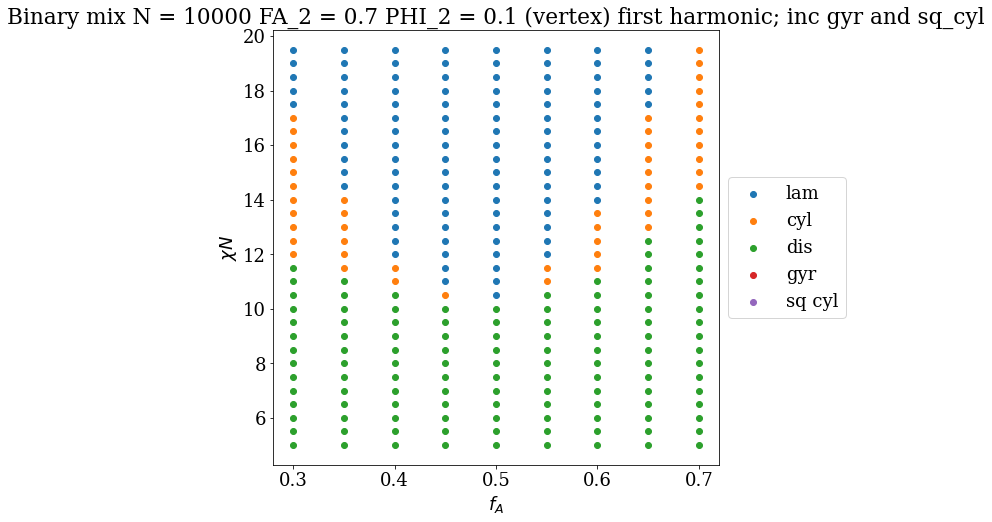

In [228]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)


# ax.plot(f_as, polyd_spin_array_vertex*N, label="monodisperse spinodal", color = "black")#, zorder = 0)
ax.scatter(lam_pnts[::2], lam_pnts[1::2], label = "lam")
ax.scatter(cyl_pnts[::2], cyl_pnts[1::2], label = "cyl")
ax.scatter(dis_pnts[::2], dis_pnts[1::2], label = "dis")
ax.scatter(gyr_pnts[::2], gyr_pnts[1::2], label = "gyr")
ax.scatter(sq_cyl_pnts[::2], sq_cyl_pnts[1::2], label = "sq cyl")
# ax.scatter([0.3, 0.4, 0.5], [19.204, 11.338, 8.981], label = "solv eff N=10 cyl/lam")
# ax.scatter([0.4, 0.5], [12.96, 10.25], label = "solv eff N=100 cyl/lam")

# ax.scatter([0.4, 0.425], [12.711, 11.689], label = "milner cyl/lam") #no gyr
# ax.scatter([0.375, 0.4, 0.425, .425, 0.44, 0.408], [12.745, 12.111, 11.512, 12.033, 11.25, 12.75], color = "brown", label = "milner gyroid")
# ax.scatter([0.4, 0.42, 0.42, 0.44, 0.44, 0.45], [12.722, 11.915, 13.044, 11.310, 11.671, 11.169], color = "purple", label = "matsen bates gyroid")


box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Binary mix N = " + str(N) + " FA_2 = " +  str(np.round(FA_2, 2)) +  " PHI_2 = " +str(np.round(1 - PHI_1, 2)) + " (vertex) first harmonic; inc gyr and sq_cyl")
ax.set_ylabel("$\chi N$")
ax.set_xlabel("$f_A$")
# ax.set_ylim(10, 13)

In [229]:
%%time
#SINGLE WAVEMODE PHASE DIAGRAM binary mixture
N = 10000
N_1 = N
N_2 = N_1

PHI_1 = 0.0
FA_2 = 0.7

fa_array = [0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45, 0.475, 0.5]#[0.3, 0.325, 0.35, 0.375, 0.3875, 0.4, 0.4125, 0.425, 0.4375, 0.45, 0.475, 0.5]#[0.3, 0.35, 0.4, 0.45, 0.5]#np.arange(0.2, 0.51, .02)
fa_array = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7] 
chi_array = np.arange(5, 20, 0.5)/N #np.arange(5, 30, 0.5)/N #np.array([5, 7, 10, 12, 15, 17, 20])/N #* N
cyl_pnts = np.array([])
lam_pnts = np.array([])
gyr_pnts = np.array([])
sq_cyl_pnts = np.array([])
dis_pnts = np.array([])

for FA_1 in fa_array:
    KS = spinodal_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1)
    q_star = KS[0]

    lam_q = q_star*np.array([1, 0, 0])
    
    cyl_q1 = q_star*np.array([1, 0, 0])
    cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
    cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
    cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])
    
    sq_6 = (1/np.sqrt(6)) * q_star
    gyr_q1 = sq_6*np.array([-1, 2, 1])
    gyr_q2 = sq_6*np.array([2, 1, -1])
    gyr_q3 = sq_6*np.array([1, -1, 2])
    gyr_q4 = sq_6*np.array([2, -1, -1])
    gyr_q5 = sq_6*np.array([-1, 2, -1])
    gyr_q6 = sq_6*np.array([-1, -1, 2])
    
    gyr_q7 = sq_6*np.array([2, 1, 1])
    gyr_q8 = sq_6*np.array([1, 2, 1])
    gyr_q9 = sq_6*np.array([1, 1, 2])
    gyr_q10 = sq_6*np.array([2, -1, 1])
    gyr_q11 = sq_6*np.array([1, 2, -1])
    gyr_q12 = sq_6*np.array([-1, 1, 2])
    
    sq_cyl_q1 = q_star * np.array([1,0,0])
    sq_cyl_q2 = q_star * np.array([0,1,0])
    
    lam_g3 = 0
    
    cyl_g3 = (1/6) * (1/(3*np.sqrt(3))) * 12 * gamma3_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, cyl_qs)
        
    gyr_g3 = (1/6) * (1/(12*np.sqrt(12))) * 48 * gamma3_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q7, -gyr_q11, -gyr_q3]))
    
    sq_cyl_g3 = 0
    
    lam_g4 = (1/24) * (6) * (1) * gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([lam_q, -lam_q, lam_q, -lam_q]))
    
    cyl_g4 = (1/12)* (gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ])) + \
              4*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2])))
    
    gyr_g4 = (1/48) * (gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q1, -gyr_q1, gyr_q1, -gyr_q1])) + \
                       4*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q7, -gyr_q7, gyr_q8, -gyr_q8])) + \
                       4*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q7, -gyr_q7, gyr_q10, -gyr_q10])) + \
                       4*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q7, -gyr_q7, gyr_q11, -gyr_q11])) + \
                       2*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q7, -gyr_q7, gyr_q4, -gyr_q4])) + \
                       8*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q7, -gyr_q7, gyr_q12, -gyr_q12])) + \
                       -4*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q1, gyr_q4, -gyr_q10, -gyr_q5])) + \
                       2*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q7, -gyr_q2, gyr_q4, -gyr_q10])) + \
                       -4*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([gyr_q1, -gyr_q5, -gyr_q7, gyr_q2])))
    
    sq_cyl_g4 = (1/24) * (1/4) * (12*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([sq_cyl_q1 , -sq_cyl_q1 , sq_cyl_q1 , -sq_cyl_q1 ])) + \
                                  24*gamma4_polyd(pset, wigset, N_1, N_2, FA_1, FA_2, PHI_1, np.array([sq_cyl_q1 , -sq_cyl_q1 , sq_cyl_q2 , -sq_cyl_q2 ])))
    
    for CHI in chi_array:
        lam_g2 = (1/2) * 2 * (1) * gamma2_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, q_star, CHI)                
        
        cyl_g2 = (1/2) * 6 * (1/3) * gamma2_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, q_star, CHI) 
        
        gyr_g2 = (1/2) * 24 * (1/12) * gamma2_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, q_star, CHI)
        
        sq_cyl_g2 = (1/2) * (1/2) * 4 * gamma2_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, q_star, CHI)
                                            
        
        amp_l1 = optimize.fmin(lambda amps: np.real(amps**2 * lam_g2 + amps**3 * lam_g3 + amps**4 * lam_g4), \
                              1, disp=False)
        amp_c1 = optimize.fmin(lambda amps: np.real(amps**2 * cyl_g2 + amps**3 * cyl_g3 + amps**4 * cyl_g4), \
                              1, disp=False)
        
        amp_g1 = optimize.fmin(lambda amps: np.real(amps**2 * gyr_g2 + amps**3 * gyr_g3 + amps**4 * gyr_g4), \
                              1, disp=False)
        
        amp_sq_c1 = optimize.fmin(lambda amps: np.real(amps**2 * sq_cyl_g2 + amps**3 * sq_cyl_g3 + amps**4 * sq_cyl_g4), \
                              1, disp=False)
        
        lamF = amp_l1**2 * lam_g2 + amp_l1**3 * lam_g3 + amp_l1**4 * lam_g4 
        
        cylF = amp_c1**2 * cyl_g2 + amp_c1**3 * cyl_g3 + amp_c1**4 * cyl_g4 
        
        gyrF = amp_g1**2 * gyr_g2 + amp_g1**3 * gyr_g3 + amp_g1**4 * gyr_g4 
        
        sq_cylF = amp_sq_c1**2 * sq_cyl_g2 + amp_sq_c1**3 * sq_cyl_g3 + amp_sq_c1**4 * sq_cyl_g4 
        
        
        point = np.array([FA_1, CHI*N])
#         if (lamF > 0 and cylF > 0):
#             #disordered stable
#             dis_pnts = np.append(dis_pnts, point)
#         elif (lamF < cylF):
#             lam_pnts = np.append(lam_pnts, point) 
#         else:
#             cyl_pnts = np.append(cyl_pnts, point)

        if (lamF > 0 and cylF > 0 and gyrF > 0 and sq_cylF > 0):
            #disordered stable
            dis_pnts = np.append(dis_pnts, point)
        elif (lamF < cylF and lamF < gyrF and lamF < sq_cylF):
            lam_pnts = np.append(lam_pnts, point) 
        elif (cylF < gyrF and cylF < sq_cylF):
            cyl_pnts = np.append(cyl_pnts, point)
        elif (gyrF < sq_cylF):
            gyr_pnts = np.append(gyr_pnts, point)
        else:
            sq_cyl_pnts = np.append(sq_cyl_pnts, point)
            
    print("one FA done!!")
            

one FA done!!
one FA done!!
one FA done!!
one FA done!!
one FA done!!
one FA done!!
one FA done!!
one FA done!!
one FA done!!
Wall time: 1h 57min 58s


Text(0.5, 0, '$f_A$')

<Figure size 432x288 with 0 Axes>

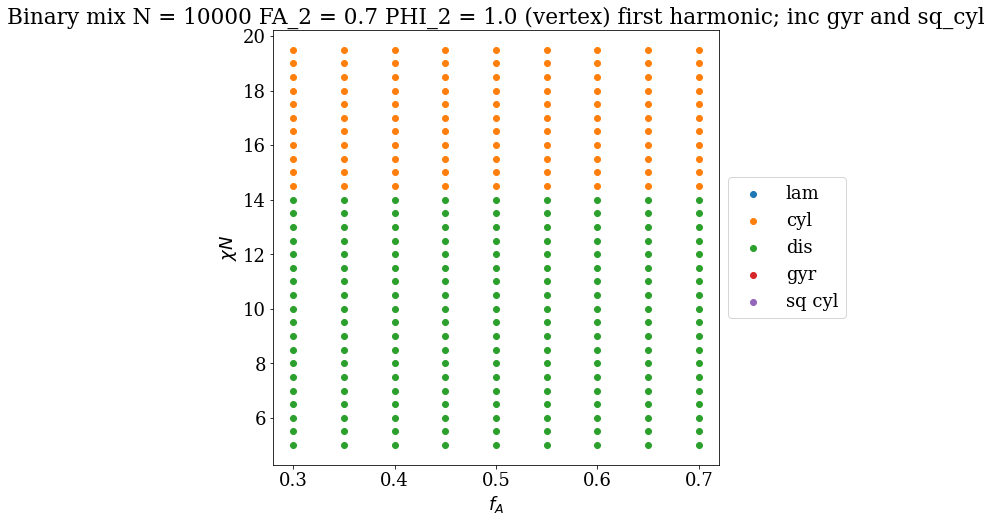

In [230]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)


# ax.plot(f_as, polyd_spin_array_vertex*N, label="monodisperse spinodal", color = "black")#, zorder = 0)
ax.scatter(lam_pnts[::2], lam_pnts[1::2], label = "lam")
ax.scatter(cyl_pnts[::2], cyl_pnts[1::2], label = "cyl")
ax.scatter(dis_pnts[::2], dis_pnts[1::2], label = "dis")
ax.scatter(gyr_pnts[::2], gyr_pnts[1::2], label = "gyr")
ax.scatter(sq_cyl_pnts[::2], sq_cyl_pnts[1::2], label = "sq cyl")
# ax.scatter([0.3, 0.4, 0.5], [19.204, 11.338, 8.981], label = "solv eff N=10 cyl/lam")
# ax.scatter([0.4, 0.5], [12.96, 10.25], label = "solv eff N=100 cyl/lam")

# ax.scatter([0.4, 0.425], [12.711, 11.689], label = "milner cyl/lam") #no gyr
# ax.scatter([0.375, 0.4, 0.425, .425, 0.44, 0.408], [12.745, 12.111, 11.512, 12.033, 11.25, 12.75], color = "brown", label = "milner gyroid")
# ax.scatter([0.4, 0.42, 0.42, 0.44, 0.44, 0.45], [12.722, 11.915, 13.044, 11.310, 11.671, 11.169], color = "purple", label = "matsen bates gyroid")


box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Binary mix N = " + str(N) + " FA_2 = " +  str(np.round(FA_2, 2)) +  " PHI_2 = " +str(np.round(1 - PHI_1, 2)) + " (vertex) first harmonic; inc gyr and sq_cyl")
ax.set_ylabel("$\chi N$")
ax.set_xlabel("$f_A$")
# ax.set_ylim(10, 13)

In [195]:
#pold spinodal
f_as = fa_array
polyd_spin_array_vertex = np.zeros(len(f_as))
chis = np.arange(8, 24, .1)/N #np.arange(8, 24, 0.1)

for i, FA_1 in enumerate(f_as):
    min_G_vals = np.zeros(len(chis))
    for j,CHI in enumerate(chis):
        #evaluate gamma2 at the chi k_spinodal for appropriate length, find when equals zero
        KS = spinodal_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1)
        G = gamma2_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, KS, CHI)
        min_G_vals[j] = G # b/c g2 is 1x1 matrix, eigenvalue is the value of g2 itself. 

    polyd_spin_array_vertex[i] = chis[np.argmin((abs(min_G_vals)))]

<ipython-input-195-daea8e977d17>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  min_G_vals[j] = G # b/c g2 is 1x1 matrix, eigenvalue is the value of g2 itself.


Text(0.5, 0, '$f_A$')

<Figure size 432x288 with 0 Axes>

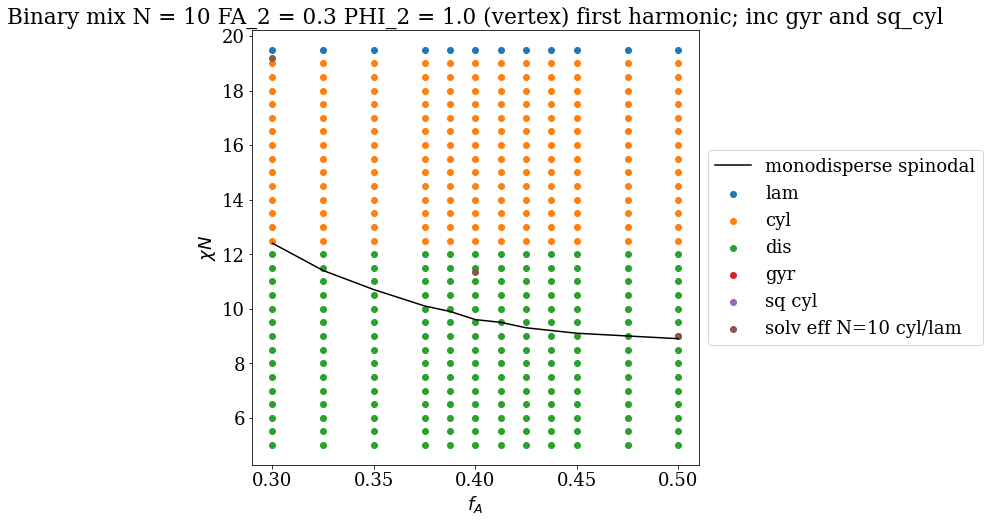

In [205]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)


ax.plot(f_as, polyd_spin_array_vertex*N, label="monodisperse spinodal", color = "black")#, zorder = 0)
ax.scatter(lam_pnts[::2], lam_pnts[1::2], label = "lam")
ax.scatter(cyl_pnts[::2], cyl_pnts[1::2], label = "cyl")
ax.scatter(dis_pnts[::2], dis_pnts[1::2], label = "dis")
ax.scatter(gyr_pnts[::2], gyr_pnts[1::2], label = "gyr")
ax.scatter(sq_cyl_pnts[::2], sq_cyl_pnts[1::2], label = "sq cyl")
ax.scatter([0.3, 0.4, 0.5], [19.204, 11.338, 8.981], label = "solv eff N=10 cyl/lam")
# ax.scatter([0.4, 0.5], [12.96, 10.25], label = "solv eff N=100 cyl/lam")

# ax.scatter([0.4, 0.425], [12.711, 11.689], label = "milner cyl/lam") #no gyr
# ax.scatter([0.375, 0.4, 0.425, .425, 0.44, 0.408], [12.745, 12.111, 11.512, 12.033, 11.25, 12.75], color = "brown", label = "milner gyroid")
# ax.scatter([0.4, 0.42, 0.42, 0.44, 0.44, 0.45], [12.722, 11.915, 13.044, 11.310, 11.671, 11.169], color = "purple", label = "matsen bates gyroid")


box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Binary mix N = " + str(N) + " FA_2 = " +  str(np.round(FA_2, 2)) +  " PHI_2 = " +str(np.round(1 - PHI_1, 2)) + " (vertex) first harmonic; inc gyr and sq_cyl")
ax.set_ylabel("$\chi N$")
ax.set_xlabel("$f_A$")
# ax.set_ylim(10, 13)

Text(0.5, 0, '$f_A$')

<Figure size 432x288 with 0 Axes>

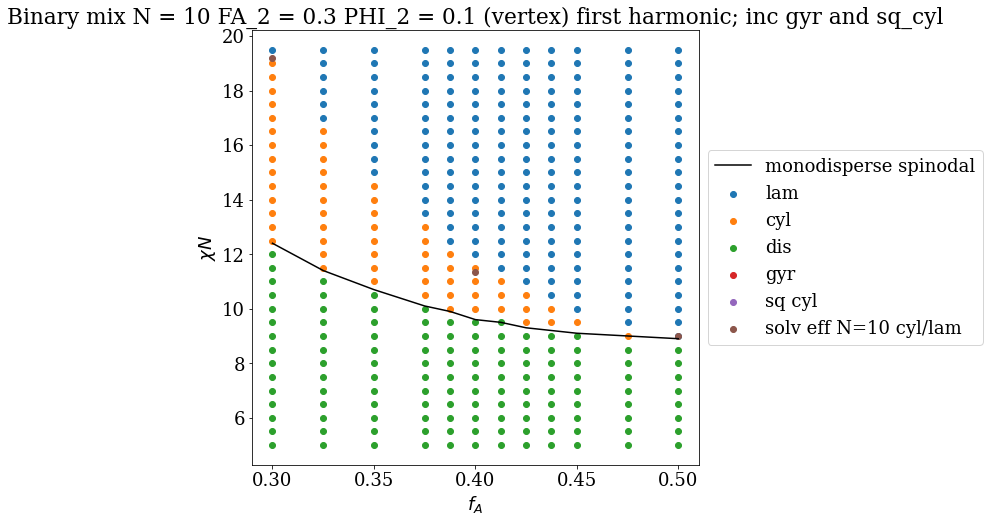

In [201]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)


ax.plot(f_as, polyd_spin_array_vertex*N, label="monodisperse spinodal", color = "black")#, zorder = 0)
ax.scatter(lam_pnts[::2], lam_pnts[1::2], label = "lam")
ax.scatter(cyl_pnts[::2], cyl_pnts[1::2], label = "cyl")
ax.scatter(dis_pnts[::2], dis_pnts[1::2], label = "dis")
ax.scatter(gyr_pnts[::2], gyr_pnts[1::2], label = "gyr")
ax.scatter(sq_cyl_pnts[::2], sq_cyl_pnts[1::2], label = "sq cyl")
ax.scatter([0.3, 0.4, 0.5], [19.204, 11.338, 8.981], label = "solv eff N=10 cyl/lam")
# ax.scatter([0.4, 0.5], [12.96, 10.25], label = "solv eff N=100 cyl/lam")

# ax.scatter([0.4, 0.425], [12.711, 11.689], label = "milner cyl/lam") #no gyr
# ax.scatter([0.375, 0.4, 0.425, .425, 0.44, 0.408], [12.745, 12.111, 11.512, 12.033, 11.25, 12.75], color = "brown", label = "milner gyroid")
# ax.scatter([0.4, 0.42, 0.42, 0.44, 0.44, 0.45], [12.722, 11.915, 13.044, 11.310, 11.671, 11.169], color = "purple", label = "matsen bates gyroid")


box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Binary mix N = " + str(N) + " FA_2 = " +  str(np.round(FA_2, 2)) +  " PHI_2 = " +str(np.round(1 - PHI_1, 2)) + " (vertex) first harmonic; inc gyr and sq_cyl")
ax.set_ylabel("$\chi N$")
ax.set_xlabel("$f_A$")
# ax.set_ylim(10, 13)

Text(0.5, 0, '$f_A$')

<Figure size 432x288 with 0 Axes>

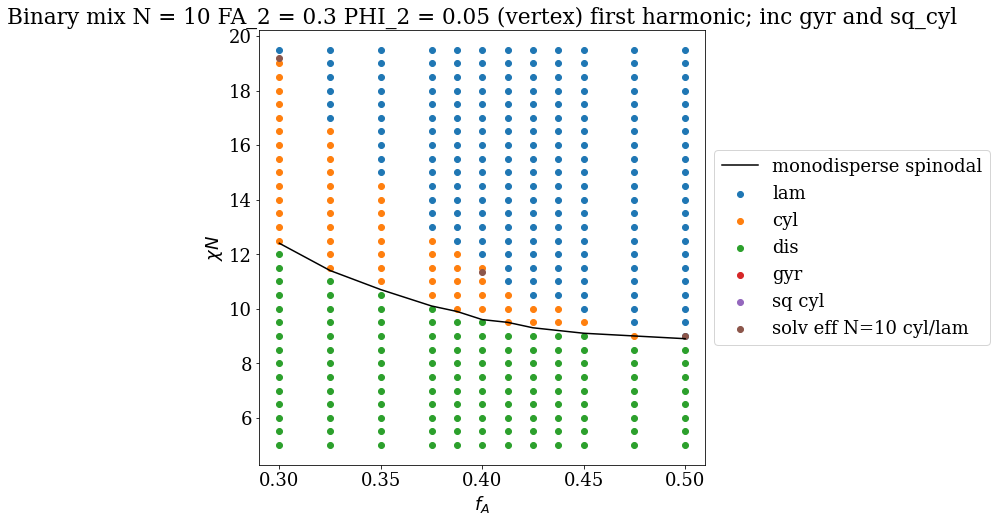

In [199]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)


ax.plot(f_as, polyd_spin_array_vertex*N, label="monodisperse spinodal", color = "black")#, zorder = 0)
ax.scatter(lam_pnts[::2], lam_pnts[1::2], label = "lam")
ax.scatter(cyl_pnts[::2], cyl_pnts[1::2], label = "cyl")
ax.scatter(dis_pnts[::2], dis_pnts[1::2], label = "dis")
ax.scatter(gyr_pnts[::2], gyr_pnts[1::2], label = "gyr")
ax.scatter(sq_cyl_pnts[::2], sq_cyl_pnts[1::2], label = "sq cyl")
ax.scatter([0.3, 0.4, 0.5], [19.204, 11.338, 8.981], label = "solv eff N=10 cyl/lam")
# ax.scatter([0.4, 0.5], [12.96, 10.25], label = "solv eff N=100 cyl/lam")

# ax.scatter([0.4, 0.425], [12.711, 11.689], label = "milner cyl/lam") #no gyr
# ax.scatter([0.375, 0.4, 0.425, .425, 0.44, 0.408], [12.745, 12.111, 11.512, 12.033, 11.25, 12.75], color = "brown", label = "milner gyroid")
# ax.scatter([0.4, 0.42, 0.42, 0.44, 0.44, 0.45], [12.722, 11.915, 13.044, 11.310, 11.671, 11.169], color = "purple", label = "matsen bates gyroid")


box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Binary mix N = " + str(N) + " FA_2 = " +  str(np.round(FA_2, 2)) +  " PHI_2 = " +str(np.round(1 - PHI_1, 2)) + " (vertex) first harmonic; inc gyr and sq_cyl")
ax.set_ylabel("$\chi N$")
ax.set_xlabel("$f_A$")
# ax.set_ylim(10, 13)

Text(0.5, 0, '$f_A$')

<Figure size 432x288 with 0 Axes>

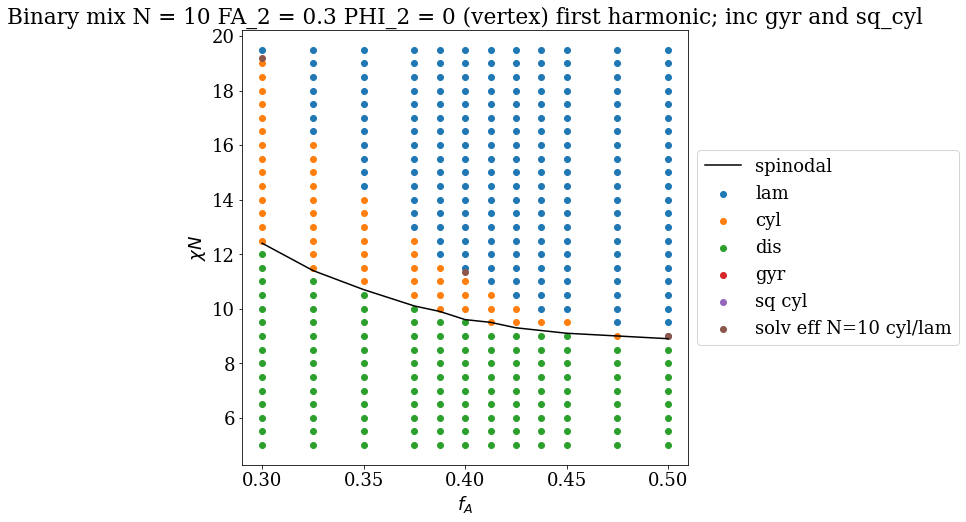

In [196]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)


ax.plot(f_as, polyd_spin_array_vertex*N, label="spinodal", color = "black")#, zorder = 0)
ax.scatter(lam_pnts[::2], lam_pnts[1::2], label = "lam")
ax.scatter(cyl_pnts[::2], cyl_pnts[1::2], label = "cyl")
ax.scatter(dis_pnts[::2], dis_pnts[1::2], label = "dis")
ax.scatter(gyr_pnts[::2], gyr_pnts[1::2], label = "gyr")
ax.scatter(sq_cyl_pnts[::2], sq_cyl_pnts[1::2], label = "sq cyl")
ax.scatter([0.3, 0.4, 0.5], [19.204, 11.338, 8.981], label = "solv eff N=10 cyl/lam")
# ax.scatter([0.4, 0.5], [12.96, 10.25], label = "solv eff N=100 cyl/lam")

# ax.scatter([0.4, 0.425], [12.711, 11.689], label = "milner cyl/lam") #no gyr
# ax.scatter([0.375, 0.4, 0.425, .425, 0.44, 0.408], [12.745, 12.111, 11.512, 12.033, 11.25, 12.75], color = "brown", label = "milner gyroid")
# ax.scatter([0.4, 0.42, 0.42, 0.44, 0.44, 0.45], [12.722, 11.915, 13.044, 11.310, 11.671, 11.169], color = "purple", label = "matsen bates gyroid")


box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Binary mix N = " + str(N) + " FA_2 = " +  str(np.round(FA_2, 2)) +  " PHI_2 = " +str(np.round(1 - PHI_1, 2)) + " (vertex) first harmonic; inc gyr and sq_cyl")
ax.set_ylabel("$\chi N$")
ax.set_xlabel("$f_A$")
# ax.set_ylim(10, 13)